In [ ]:
!pip instal pandas numpy matplotlib seaborn nltk tqdm sentence_transformers datasets turftopic plotly

: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from tqdm import tqdm

from turftopic import KeyNMF
import plotly
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

from datasets import load_dataset

# Define your custom palette
custom_palette = ['#E9D758', '#297373', '#FF8552']

In [3]:
def remove_tokens_with_digits(text):
    return ' '.join([word for word in text.split() if not re.search(r'\d', word)])

### Load dataset

In [4]:
from huggingface_hub import login

login()

In [5]:
# Load dataset
dataset = load_dataset("awlassche/periphery-aviser-e5", split='train')

README.md:   0%|          | 0.00/758 [00:00<?, ?B/s]

train-00000-of-00013.parquet:   0%|          | 0.00/369M [00:00<?, ?B/s]

train-00001-of-00013.parquet:   0%|          | 0.00/369M [00:00<?, ?B/s]

train-00002-of-00013.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

train-00003-of-00013.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

train-00004-of-00013.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

train-00005-of-00013.parquet:   0%|          | 0.00/384M [00:00<?, ?B/s]

train-00006-of-00013.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

train-00007-of-00013.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

train-00008-of-00013.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

train-00009-of-00013.parquet:   0%|          | 0.00/381M [00:00<?, ?B/s]

train-00010-of-00013.parquet:   0%|          | 0.00/369M [00:00<?, ?B/s]

train-00011-of-00013.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

train-00012-of-00013.parquet:   0%|          | 0.00/384M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/685021 [00:00<?, ? examples/s]

In [6]:
df = dataset.to_pandas()
df.shape

(685021, 13)

In [7]:
print(df['date'].min(), df['date'].max())

# Create a complete date range from the minimum to the maximum date in your data
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D').to_period('D')

# Create a complete monthly date range from the minimum to the maximum date in your data
full_month_range = pd.period_range(start=df['date'].min(), end=df['date'].max(), freq='M')

1809-01-01 1848-12-30


In [8]:
newspapers = ['aal', 'lol', 'ode', 'thi', 'vib']
newspaper_dict = {'aal': 'Aalborg', 'lol': 'Lolland-Falster', 'ode': 'Odense', 'thi': 'Thisted', 'vib': 'Viborg'}

Text(0, 0.5, 'Frequency')

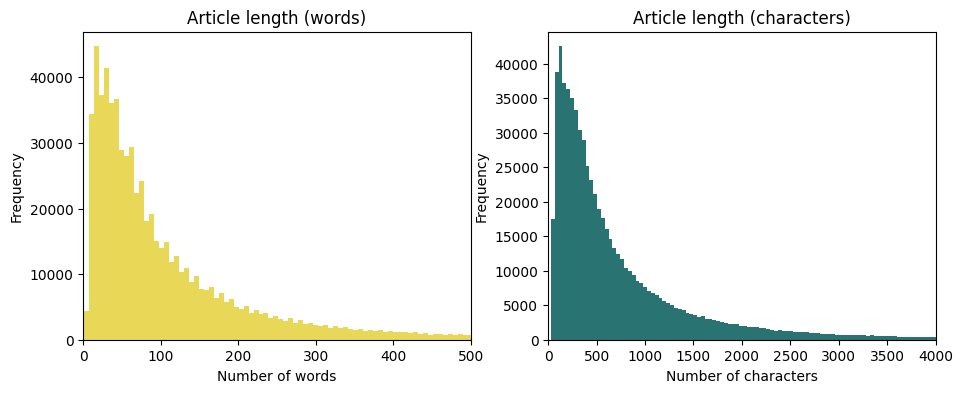

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=False)

df['article_length'].plot(kind='hist', bins=800, color='#E9D758', ax=axes[0])
axes[0].set_xlim(0,500)
axes[0].set_title('Article length (words)')
axes[0].set_xlabel('Number of words')
axes[0].set_ylabel('Frequency')

df['characters'].plot(kind='hist', bins=800, color='#297373', ax=axes[1])
axes[1].set_xlim(0,4000)
axes[1].set_title('Article length (characters)')
axes[1].set_xlabel('Number of characters')
axes[1].set_ylabel('Frequency')

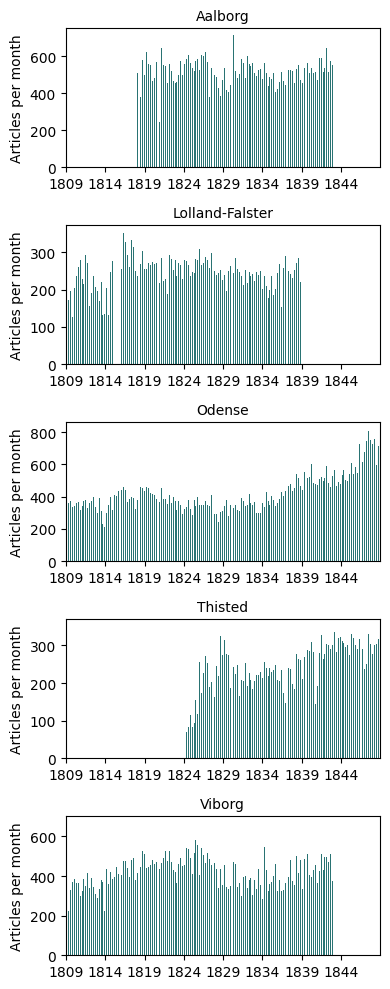

In [10]:
# Create a figure with 5 subplots in one row
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(4, 10), sharex=False)

# Determine the first January in the full_month_range
first_year = None
for period in full_month_range:
    if period.month == 1:
        first_year = period.year
        break

# Loop over each newspaper and its corresponding subplot axis
for ax, nsp in zip(axes, newspapers):
    subset = df[df['newspaper'] == nsp].copy()
    subset['date'] = pd.to_datetime(subset['date'])
    
    # Group by month and count articles, ensuring all months are represented
    month_counts = subset.groupby(subset['date'].dt.to_period('M'))['date'].count()
    month_counts = month_counts.reindex(full_month_range, fill_value=0)
    
    # Plot the data on the provided axis
    month_counts.plot(kind='bar', ax=ax, color='#297373')
    
    # Create tick positions and labels based on the full_month_range:
    # Only label ticks for January and only if (year - first_year) is a multiple of 5.
    tick_positions = []
    tick_labels = []
    for i, period in enumerate(full_month_range):
        if period.month == 1 and first_year is not None and ((period.year - first_year) % 5 == 0):
            tick_positions.append(i)
            tick_labels.append(str(period.year))
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0)
    
    #ax.set_xlabel('Date')
    ax.set_ylabel('Articles per month')
    ax.set_title(f'{newspaper_dict[nsp]}', fontsize=10)

plt.tight_layout()
plt.savefig('../figures/newspaper_distribution.pdf', bbox_inches='tight')
plt.show()

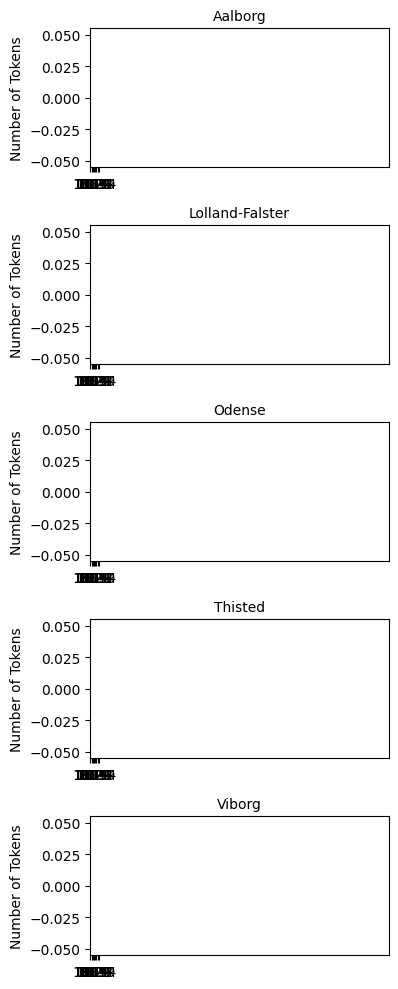

In [15]:
# Create a figure with 5 subplots in one row
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(4, 10), sharex=False)

# Determine the first January in the full_month_range
first_year = None
for period in full_month_range:
    if period.month == 1:
        first_year = period.year
        break

# Loop over each newspaper and its corresponding subplot axis
for ax, nsp in zip(axes, newspapers):
    subset = df[df['newspaper'] == nsp].copy()
    subset['date'] = pd.to_datetime(subset['date'])

    token_counts = subset.groupby(subset['date'].dt.to_period('M'))['article_length'].sum()
    token_counts = token_counts.reindex(full_date_range, fill_value=0)
    token_counts.plot(kind='bar', ax=ax, color='teal')

    # Create tick positions and labels based on the full_month_range:
    # Only label ticks for January and only if (year - first_year) is a multiple of 5.
    tick_positions = []
    tick_labels = []
    for i, period in enumerate(full_month_range):
        if period.month == 1 and first_year is not None and ((period.year - first_year) % 5 == 0):
            tick_positions.append(i)
            tick_labels.append(str(period.year))
    
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0)

    ax.set_ylabel('Number of Tokens')
    ax.set_title(f'{newspaper_dict[nsp]}', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Ensure embeddings are stored as NumPy arrays (if they are lists)
df['embedding'] = df['embedding'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

# Get unique newspapers
unique_newspapers = df['newspaper'].unique()

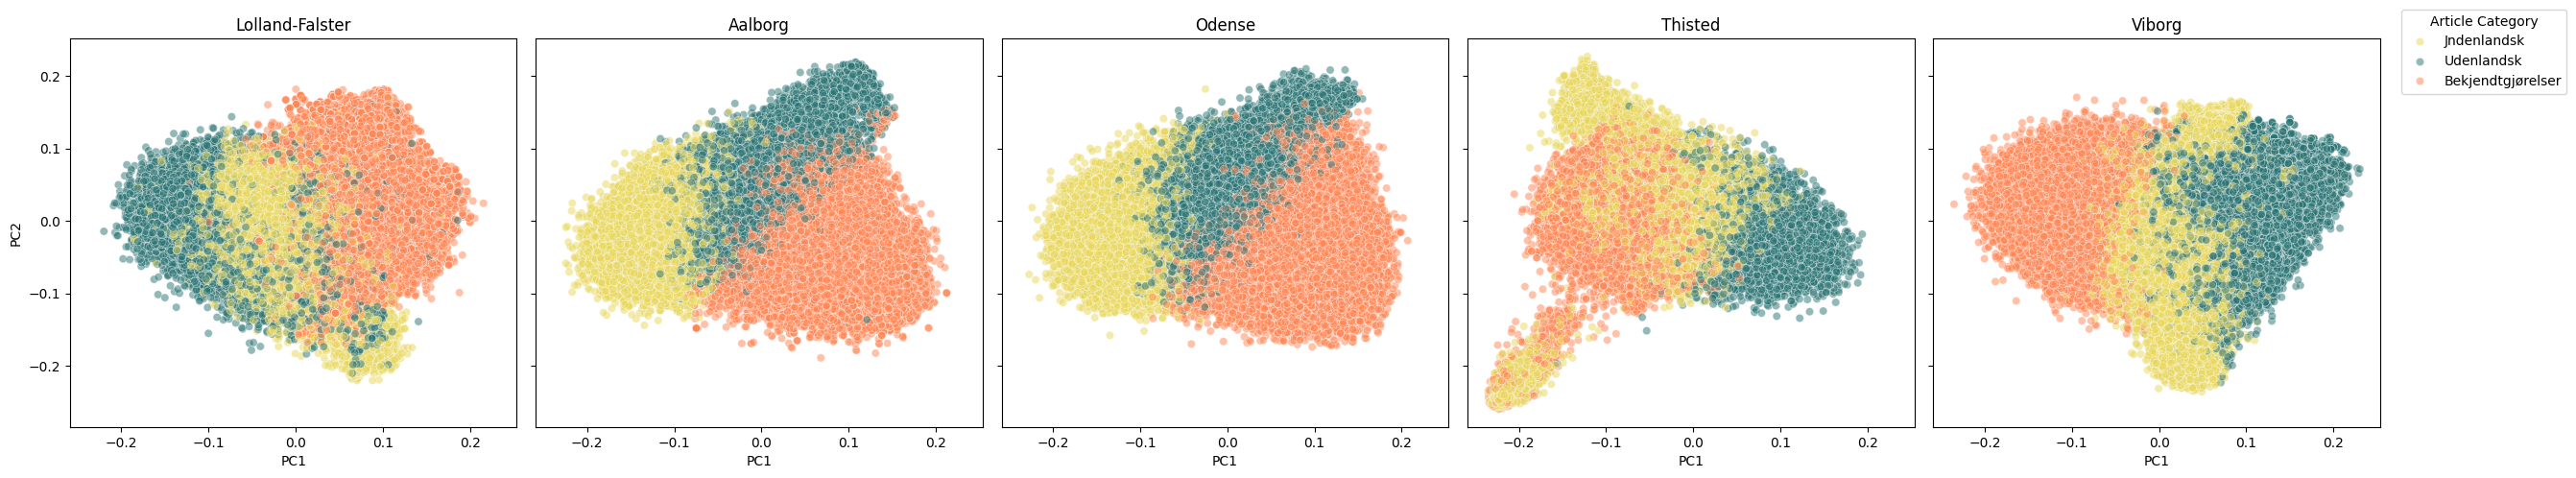

In [13]:
# Create a figure with subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

# Loop through each newspaper and plot in a subplot
for i, newspaper in enumerate(unique_newspapers):
    # Filter the DataFrame for the specific newspaper
    df_filtered = df[df['newspaper'] == newspaper]

    # Skip if there are no embeddings for this newspaper
    if df_filtered.empty:
        continue

    # Stack embeddings into a NumPy array
    embeddings_matrix = np.vstack(df_filtered['embedding'].values)

    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings_matrix)

    # Create a DataFrame for visualization
    pca_df = pd.DataFrame(embeddings_pca, columns=['PC1', 'PC2'])
    pca_df['clean_category'] = df_filtered['clean_category'].values  # Assign categories

    # Plot the PCA results in a subplot
    ax = axes[i]
    sns.scatterplot(
        x='PC1', y='PC2', hue='clean_category', data=pca_df, palette=custom_palette, alpha=0.5, ax=ax
    )
    ax.set_title(f"{newspaper_dict[newspaper]}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend([], [], frameon=False)  # Remove individual legends

# Adjust layout and show a single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Article Category", bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../figures/PCA_e5.pdf')
plt.show()

### Find books in announcements

In [34]:
# Make subset with announcements
df_announcements = df[df['clean_category'] == 'Bekjendtgjørelser']

# Your list of substrings to match
keywords = ['bog', 'bøger', 'boglade'] #, 'paa adressekontoiret faaes']

# Build regex pattern to match at word-start
pattern = r'\b(' + '|'.join(re.escape(word) for word in keywords) + ')'

# Filter the DataFrame
boger_df = df_announcements[df_announcements['text'].str.contains(pattern, case=False, na=False)]
boger_df.shape

/tmp/ipykernel_1545/2721093873.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  boger_df = df_announcements[df_announcements['text'].str.contains(pattern, case=False, na=False)]


(21046, 13)

In [37]:
boger_df.head()

,article_id,date,embedding,n_chunks_orig,clean_category,nøgle,text,category,article_length,characters,embedding_shape,newspaper,label_type
35,lol_000036,1809-03-07,"[0.023587369127199054, 0.0073470682837069035, ...",2,Bekjendtgjørelser,1809-03-07_49,Ladningen udsælges i større eller mindre Qvant...,Bekiendtgiørelser,90,572,[1024],lol,gold
37,lol_000038,1809-03-07,"[0.03518466651439667, 0.009328734129667282, -0...",1,Bekjendtgjørelser,1809-03-07_52,Paa Addresse-Contoiret i Mariboe bekommes følg...,Bekiendtgiørelser,76,475,[1024],lol,gold
63,lol_000064,1809-03-10,"[0.02332383394241333, 0.014926900155842304, -0...",2,Bekjendtgjørelser,1809-03-10_89,Paa Addresse=Contoiret i Mariboe bekommes følg...,Bekiendtgiørelser,121,768,[1024],lol,gold
88,lol_000089,1809-03-14,"[0.021266561932861805, 0.009268472126374641, -...",3,Bekjendtgjørelser,1809-03-14_130,De Høistærede Herrer der have beviist mig den ...,Bekiendtgiørelser,176,1177,[1024],lol,gold
107,lol_000108,1809-03-17,"[0.045772675424814224, 0.020751845091581345, -...",1,Bekjendtgjørelser,1809-03-17_173,Paa Mariboe Addresse-Contoir kan følgende Bøge...,Bekiendtgiørelser,7,65,[1024],lol,gold


In [38]:
boger_df[['article_id', 'date', 'text']].to_csv('../data/boger.csv')

### KeyNMF

In [16]:
# load model with which embeddings are created
trf = SentenceTransformer('intfloat/multilingual-e5-large')

# load stopword list
with open('../../danske-aviser/notebooks/stopwords-da_txt.txt') as file:
    stop_words = file.read().split()

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

threshold for number of characters vs digits in text

In [58]:
import textdescriptives

ModuleNotFoundError: No module named 'textdescriptives'

In [17]:
# make subset of only one newspaper category
df_indenlandsk = df[df['clean_category'] == 'Bekjendtgjørelser']
df_indenlandsk.shape

# create balanced sample over different newspapers
balanced_df_indenlandsk = df_indenlandsk.groupby('newspaper', group_keys=False).apply(
    lambda x: x.sample(n=500, replace=True) if len(x) >= 200 else x
).reset_index(drop=True)
balanced_df_indenlandsk.shape

# prepare corpus for KeyNMF
corpus = balanced_df_indenlandsk['text'].tolist()
cleaned_corpus = [remove_tokens_with_digits(text) for text in corpus]

# prepare embeddings for KeyNMF
embeddings_matrix = np.vstack(balanced_df_indenlandsk['embedding'].values)

/tmp/ipykernel_316/3402855461.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df_indenlandsk = df_indenlandsk.groupby('newspaper', group_keys=False).apply(


In [18]:
seeded_model = KeyNMF(10, top_n=15, encoder=trf, vectorizer=CountVectorizer(stop_words=stop_words, min_df=50, max_df=0.85), seed_phrase='Hvilke bøger er til salg?', random_state=42)
seeded_model.fit(cleaned_corpus, embeddings=embeddings_matrix)

Output()

[14:54:24] Keyword extraction done.                                                                   ]8;id=775370;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py\keynmf.py]8;;\:]8;id=885029;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py#219\219]8;;\

           Model fitting done.                                                                        ]8;id=317996;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py\keynmf.py]8;;\:]8;id=683502;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py#226\226]8;;\

KeyNMF(encoder=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': F...
       n_components=10, random_state=42,
       seed_phrase='Hvilke bøger er til salg?', top_n=15,
       vectorizer=CountVectorizer(max_df=0.85, min_df=50,
                                  stop_words=['ad', 'af', 'aldrig', 'alle',
                                              'alt', 'anden', 'andet', 'andre',
                                              'at', 'bare', 'begge', 'blev',
                                              'bleven', 'blive', 'bliver', 'da',
                                              'de', 'dem', 'den', 'denne',
                                              'dennes', 'der', 'deres', 'det',
                                              'dette', 'dig', 'din', 'dine',
                                              'disse', 'dit', ...]))

In [19]:
seeded_model.print_topics() # seed

┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Topic ID ┃ Highest Ranking                                                                                      ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        0 │ auction, offentlig, bestaaende, sengeklæder, afholdt, bortsælge, bortsolgt, næstkommende, byen,      │
│          │ auctionsstedet                                                                                       │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        1 │ varsel, anmelde, indkaldes, beviisliggjøre, afdøde, skifteforvalter, fordringer, proclama,           │
│          │ vedkommende, ugers                                                                                   │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        2 │ undertegnede, henvende, anbefaler, modtages, tillige, sikkerhed, erholdes, ønske, bortsælge,         │
│          │ underhaanden                                                                                         │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        3 │ tilhørende, afholdes, beliggende, gaard, auctioner, første, gaarden, sogn, eiendommen, tilliggende   │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        4 │ bekjendtgjøres, efterretning, vedkommende, vedkommendes, odense, afholdes, raadstue, kjøbmand,       │
│          │ afholdt, avertissements                                                                              │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        5 │ thisted, lund, forsendes, allernaadigst, privilegerede, brevposten, kongelig, avertissements,        │
│          │ danmark, bemærkes                                                                                    │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        6 │ conditionerne, lysthavende, indbydes, eftersyn, auctionen, erfares, afholdes, auctionsstedet,        │
│          │ contoir, møde                                                                                        │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        7 │ dage, inden, sølv, rbd, bør, vedkommende, første, ere, kongelige, betale                             │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        8 │ førstkommende, foretaget, møde, bemeldte, afholdt, odense, licitation, vedkommendes, gaard,          │
│          │ tilhørende                                                                                           │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        9 │ tilkjøbs, odense, gode, erholdes, priser, erholde, billige, billig, henvende, henvender              │
└──────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [20]:
seedless_model = KeyNMF(10, top_n=15, encoder=trf, vectorizer=CountVectorizer(stop_words=stop_words, min_df=50, max_df=0.85), random_state=42)
seedless_model.fit(cleaned_corpus, embeddings=embeddings_matrix)

Output()

[15:32:30] Keyword extraction done.                                                                   ]8;id=412750;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py\keynmf.py]8;;\:]8;id=812829;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py#219\219]8;;\

           Model fitting done.                                                                        ]8;id=101266;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py\keynmf.py]8;;\:]8;id=623006;file:///home/ucloud/.local/lib/python3.12/site-packages/turftopic/models/keynmf.py#226\226]8;;\

KeyNMF(encoder=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': F...e_prompt': True})
  (2): Normalize()
),
       n_components=10, random_state=42, top_n=15,
       vectorizer=CountVectorizer(max_df=0.85, min_df=50,
                                  stop_words=['ad', 'af', 'aldrig', 'alle',
                                              'alt', 'anden', 'andet', 'andre',
                                              'at', 'bare', 'begge', 'blev',
                                              'bleven', 'blive', 'bliver', 'da',
                                              'de', 'dem', 'den', 'denne',
                                              'dennes', 'der', 'deres', 'det',
                                              'dette', 'dig', 'din', 'dine',
                                              'disse', 'dit', ...]))

In [21]:
seedless_model.print_topics() # seed

┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Topic ID ┃ Highest Ranking                                                                                      ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        0 │ auction, offentlig, bestaaende, sengeklæder, afholdt, bortsælge, bortsolgt, næstkommende, byen,      │
│          │ auctionsstedet                                                                                       │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        1 │ varsel, anmelde, indkaldes, beviisliggjøre, afdøde, skifteforvalter, fordringer, proclama, ugers,    │
│          │ vedkommende                                                                                          │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        2 │ undertegnede, henvende, anbefaler, modtages, tillige, sikkerhed, erholdes, ønske, bortsælge,         │
│          │ underhaanden                                                                                         │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        3 │ tilhørende, afholdes, beliggende, gaard, auctioner, første, gaarden, sogn, eiendommen, tilliggende   │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        4 │ bekjendtgjøres, efterretning, vedkommende, vedkommendes, odense, afholdes, raadstue, avertissements, │
│          │ kjøbmand, afholdt                                                                                    │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        5 │ thisted, forsendes, lund, allernaadigst, privilegerede, brevposten, kongelig, avertissements,        │
│          │ danmark, bemærkes                                                                                    │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        6 │ conditionerne, lysthavende, indbydes, eftersyn, auctionen, erfares, afholdes, auctionsstedet,        │
│          │ contoir, møde                                                                                        │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        7 │ dage, inden, sølv, rbd, bør, vedkommende, ere, kongelige, første, betale                             │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        8 │ førstkommende, foretaget, møde, bemeldte, afholdt, odense, licitation, vedkommendes, gaard,          │
│          │ tilhørende                                                                                           │
├──────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────┤
│        9 │ tilkjøbs, odense, gode, erholdes, priser, erholde, billige, henvende, billig, henvender              │
└──────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [22]:
print(np.allclose(seeded_model.components_, seedless_model.components_))

False
